# Forecasting with Seasonal SVR
This notebook contains time series preparation, grid search for SVR parameters, model fitting, model evaluation, forecasting and an accuracy metric

In [1]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

import matplotlib.pyplot as plt

In [2]:
# Constants

# path to dataset
PATH_CLEANED = 'data/data.pckl'

# use this path for testing purpose (sine function with noise)
#PATH_CLEANED = 'data/sine.pckl'

# time span
SPLIT = datetime(2010, 1, 1)

# frequency and period length
PERIOD = 'W'
PERIOD_LEN = 52

# differentiate time series
DIFF = False

### Loading and Preprocessing
Load and resample

In [3]:
# load dataset
data = pd.read_pickle(PATH_CLEANED)

# resample time series
ts = data['Global_active_power']
ts = ts.resample(PERIOD).mean()

# fill missing values with previous data
ts = ts.fillna(method='ffill')
ts.head()

Datetime
2006-12-17    2.505248
2006-12-24    1.734186
2006-12-31    1.958376
2007-01-07    1.484233
2007-01-14    1.604954
Freq: W-SUN, Name: Global_active_power, dtype: float64

### Split for Model Testing
Split ts in training series and evaluation series

In [4]:
# split ts in train and test range
ts_orig_train = ts[ts.index < SPLIT]
ts_orig_test = ts[ts.index >= SPLIT]

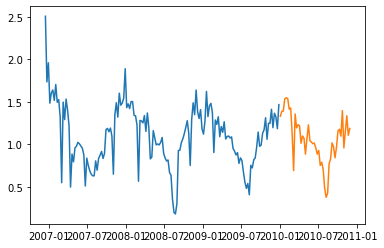

In [5]:
plt.plot(ts_orig_train)
plt.plot(ts_orig_test)
plt.show()

### Extract Seasonal Component
If DIFF == True, differenciate ts for the PERIOD_LEN interal. Removes seasonality from the series

In [6]:
if DIFF == True:
    # differenciate seasonally
    ts_train = ts_orig_train.diff(periods=PERIOD_LEN).iloc[PERIOD_LEN:]
else:
    ts_train = ts_orig_train.copy()

### Reshape
Transform to the sklearn shape

In [7]:
# reshape array to (n, 1) for sklearn models
ts_train = ts_train.values
ts_train = np.reshape(ts_train, (-1, 1))

ts_test = ts_orig_test.values
ts_test = np.reshape(ts_test, (-1, 1))

### Grid Search
Determine optimal parameters for the model by evaluation on sub-samples from the training set (expanding window). Sklearn's SVR model is not convenient for rolling window prediction, that is why it was modified to SVRRolling.

Sklearn provides functions such as GridSearchCV and TimeSeriesSplit, which are unfortunately not applicable for the recursive forecasting in this case.

In [8]:
class SVRRolling(SVR):
    '''
    SVR extension for time series forecasting
    
    Parameters:
        kernel (str): Kernel function
        C (float): Regulaization parameter
        epsilon (float): Width of epsilon tube
        _window_size (int): Number of lags to be considered for rolling window
        
    Attributes:
        _window_size (int): Number of lags to be considered for rolling window
        
    '''
    
    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1, _window_size=30):
        self._window_size = _window_size
        super().__init__(kernel=kernel, C=C, epsilon=epsilon)
        
    def _roll_data(self, dataset, max_size=10):
        start = np.empty((max_size,1))
        start[:,:] = np.nan ## maybe better removing values in the first place!!
        dataset = np.concatenate((start, dataset), axis=0)
        X = []
        for i in range(max_size, len(dataset)):
            a = dataset[(i-max_size):i]#[::-1]
            X.append(a)
        return np.array(X)[:,:,0]
        
    def fit(self, X, y=None, **kwargs):
        '''
        Fits parameters to SVR model
        
        Rolls time series before fitting to the model
        
        Parameters:
            X (np.array): ts values to be fitted, shape (num_samples, num_features)
            y: void
        '''
        
        self._y = X
        y = X[self._window_size:,0]
        X = self._roll_data(X, self._window_size)[self._window_size:]
        return super().fit(X, y, **kwargs)
        
    def predict(self, X):
        '''
        Predicts values
        
        Parameters:
            X (np.array): Test set, only needed to align with the sklearn api layout, not used for estimation
            
        Returns:
            ts (np.array): Estimated values, shape (X.shape[0], 1)
        '''
        
        # ignores the given X values and calculates from start point recursively
        length = X.shape[0]
        ts = self._y
        for i in range(length):
            a = ts[-self._window_size:]
            ts = np.concatenate((ts, [super().predict(a.reshape(1, -1))]))        
        return ts[-length:]

In [9]:
# manual grid search

# define possible parameters here:
params = {
    'kernel' : ['linear', 'rbf'],
    'C': [0.01, 0.1, 1], 
    'epsilon': [0.0001, 0.001, 0.01], 
    '_window_size': [10, 15, 20, 25, 30, 35, 40, 45, 50, 52]
}

# forecast horizon to be evaluated on
horizon = len(ts_test)
# step size for forward chaining
step_size = 2

keys, values = zip(*params.items())
param_search = [dict(zip(keys, v)) for v in itertools.product(*values)]

scaler = MinMaxScaler()

# optimal model and score
best_model = None
best_score = None

# create ts splits
buffer = max(params['_window_size']) + 1
splits = np.arange(buffer, len(ts_train) - horizon, step_size)
tscv = [(np.arange(0, i), np.arange(i, i + horizon)) for i in splits]

# loop over all param combinations
for param in param_search:
    
    metric = []
    
    # loop over all ts splits
    for train, test in tscv:
        # scale training data (and test data for coparison)
        X_train = scaler.fit_transform(ts_train[train])
        X_test = scaler.transform(ts_train[test])
        
        # create SVM
        model = SVRRolling(**param)
        model.fit(X_train)
        X_pred = model.predict(X_test)
        
        # evaluate with error metric
        score = np.sqrt(((X_test - X_pred)**2).mean())
        metric.append(score)
    
    # average metric for all ts splits
    total_score = np.array(metric).mean()
    if best_score is None:
        best_score = total_score
        best_model = model
    elif best_score > total_score:
        best_score = total_score
        best_model = model

print('Evaluated on {} tscv sets'.format(len(tscv)))
print('Best score: {}'.format(best_score))
print(best_model)

Evaluated on 29 tscv sets
Best score: 0.10920691229130425
SVRRolling(C=0.1, _window_size=35, epsilon=0.0001, kernel='rbf')


### Predict

In [10]:
# best fitting model from grid search
best_model.fit(ts_train)
ts_pred = best_model.predict(ts_test)[:,0]

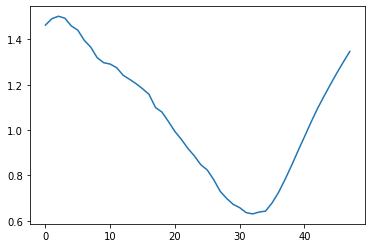

In [11]:
# show prediction
plt.plot(ts_pred)
plt.show()

### Reverse TS Differencing
Reverse the seasonal differencing to obtain absolute values

In [12]:
if DIFF == True:
    # pad with nans
    nans = int(np.ceil(len(ts_pred)/PERIOD_LEN)*PERIOD_LEN - len(ts_pred))
    ts_pred_temp = np.pad(ts_pred, (0, nans), mode='constant', constant_values=np.nan)
    ts_pred_temp = ts_pred_temp.reshape(PERIOD_LEN, -1)
    # add previous observations
    ts_pred_temp = np.concatenate((np.reshape(ts_orig_train.values, (-1, 1))[-PERIOD_LEN:], ts_pred_temp), axis=1)
    # reverse diff
    ts_pred = ts_pred_temp.cumsum(axis=1)[:,1:]
    # remove padded nans
    ts_pred = ts_pred[~np.isnan(ts_pred)]

# predicted series
ts_pred = pd.Series(ts_pred, index=ts_orig_test.index)

### Plot Series

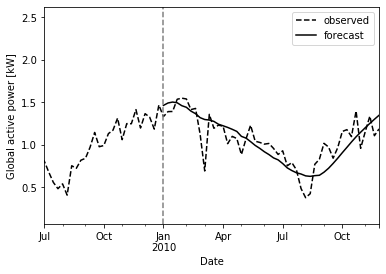

In [13]:
#plt.figure(figsize=(13.22, 4.8))
ax = ts.plot(label='observed', c='k', linestyle='--')
ts_pred.plot(ax=ax, label='forecast', c='k')
ax.set_xlabel('Date')
ax.set_ylabel('Global active power [kW]')
plt.axvline(x=SPLIT, color='k', linestyle='--', c='gray')
plt.xlim(left=pd.Timestamp(year=2009, month=7, day=1))
plt.legend()
plt.show()

### Error Metric

In [14]:
# calulate RMSE
rmse = np.sqrt(((ts_orig_test.values - ts_pred)**2).mean())
rmse

0.16994623311141674

In [15]:
# calculate MAPE
mape = np.mean(np.abs((ts_orig_test.values - ts_pred) / ts_orig_test.values)) * 100
mape

15.052552651351295

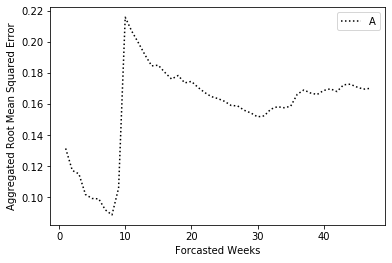

In [16]:
# error development
rmse = []
for t in range(len(ts_orig_test)):
    rmse.append(np.sqrt(((ts_orig_test.values[:t] - ts_pred[:t])**2).mean()))
plt.plot(np.arange(0, len(rmse)), rmse, c='k', linestyle=':', label='A')
plt.legend()
plt.ylabel('Aggregated Root Mean Squared Error')
plt.xlabel('Forcasted Weeks')
plt.show()